# Evaluation LLM Applications with Opik

The below example walks through the process of building a simple chatbot with a Llama model hosted in Sagemaker jumpstart, and evaluating the application with Opik.

The concepts covered in this tutorial include:

1) Defining a geography chatbot application using a placeholder context retriever + the Llama 3.2 1b model hosted with Sagemaker Jumpstart
2) Creating a dataset of questions for evaluation in Opik
3) Versioning system prompts
4) Automating the evaluation of the application on the dataset with built-in Opik metrics

## Setup Opik

Install & import Opik, and set you Opik API Key. Your API Key can be retrieved from your user menu in the top right corner of the screen. 

In [ ]:
%pip install --upgrade --quiet opik

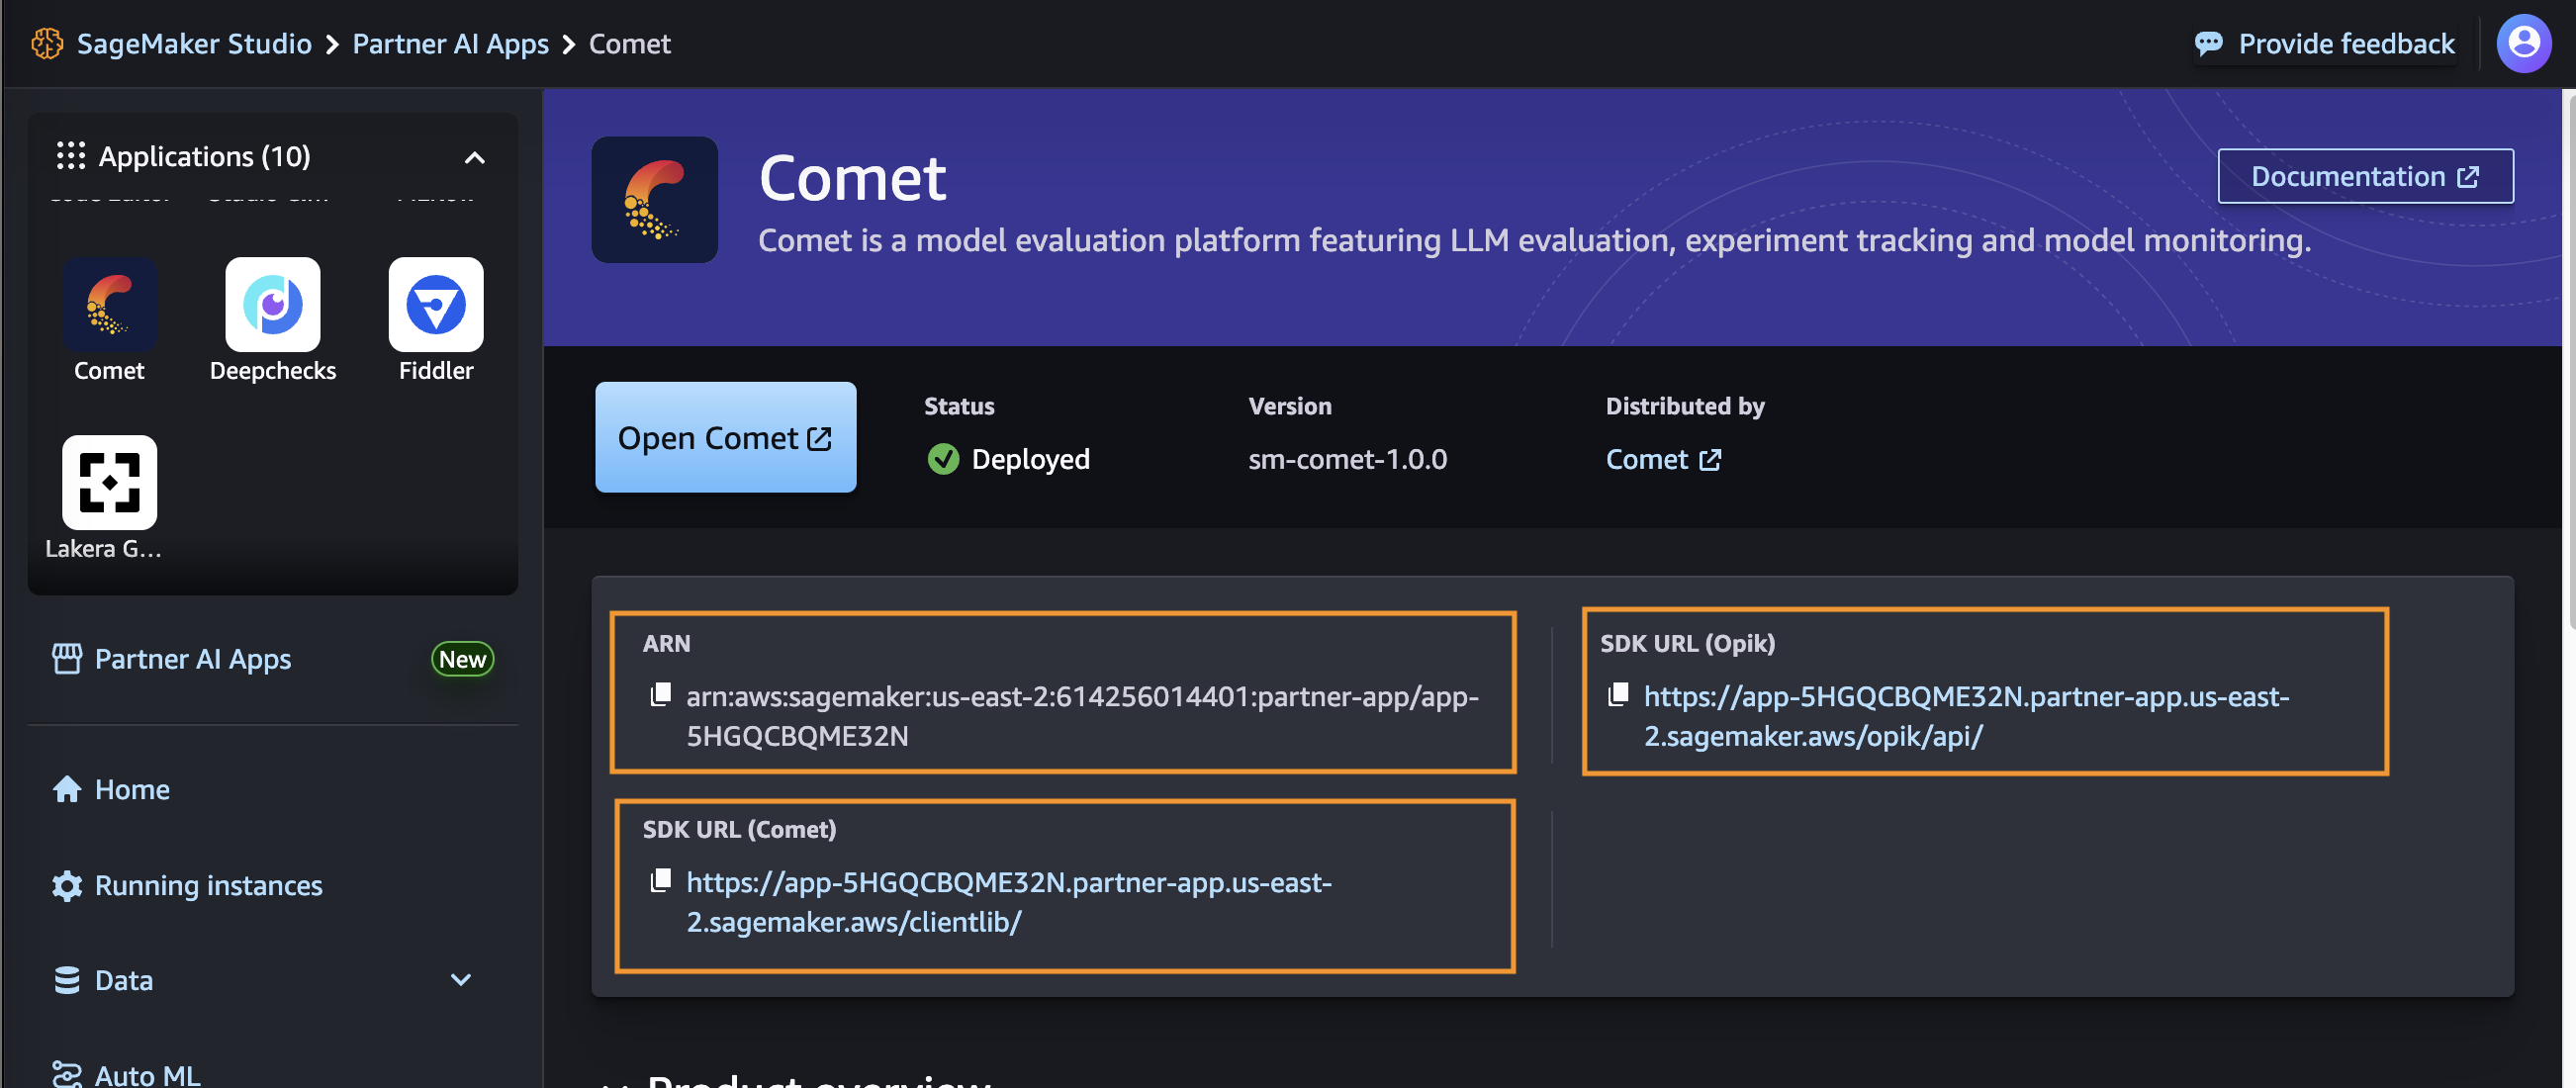

In [ ]:
import os
os.environ['AWS_PARTNER_APP_AUTH'] = 'true'
os.environ['AWS_PARTNER_APP_ARN'] = '' # Grab the ARN from SageMaker Studio -> Partner AI Apps -> Comet (View details) -> ARN
os.environ['OPIK_API_KEY'] = '' # Click Open Comet from SageMaker Studio -> Partner AI Apps -> Top right corner click on user -> API Key
os.environ["OPIK_URL_OVERRIDE"] = '' # Grab the ARN from SageMaker Studio -> Partner AI Apps -> Comet (View details) -> SDK URL (Comet)
os.environ["OPIK_WORKSPACE"] = '' # Give it a name

In [ ]:
import opik
from requests import Session
from sagemaker import PartnerAppAuthProvider

In [ ]:
import comet_ml
from comet_ml.integration.pytorch import watch

print('Comet is configured with')
print(f'URL override: {comet_ml.get_config("comet.url_override")}')
print(f'App ARN: {os.environ["AWS_PARTNER_APP_ARN"]}')
PROJECT_NAME = "llama-chatbot"
print('Logging in...')
comet_ml.login(project_name=PROJECT_NAME)
api = comet_ml.API()
print('Getting account details...')
account_details = api.get_account_details()
print(f'username: {account_details["userName"]}')
print(f'default workspace name: {account_details["defaultWorkspaceName"]}')

In [ ]:
from opik import Opik, track, opik_context
from opik.evaluation import evaluate
from opik.evaluation.metrics import IsJson
from sagemaker.predictor import Predictor
from sagemaker.predictor import retrieve_default

# Define the Application
The below code defines the LLM application that we will be evaluating. In this case, we create a Geography chatbot that 1) retrieves relevant context based on the input 2) inputs the user question into the llama model to retrieve a response. For demo purposes, the document retriever step is a placeholder with hard coded context, but this can be replaced with a real RAG step within your pipeline.

In order to ensure that the Llama calls are being tracked, we will be using the `track` decorator to track the inputs and outputs of each step of our pipeline.

Note that the `track` decorator can be used to track the input/output of calls to any model, not just Llama. Opik also features [integrations](https://www.comet.com/docs/opik/tracing/integrations/overview) with many models and frameworks for additional auto-logging of details about your model. 

In [ ]:
### RAG



class GeoBot:

    def __init__(self, endpoint_name: str = "llama-3b-endpoint"):
        self._predictor = retrieve_default(endpoint_name)
        self._endpoint = endpoint_name

    @track(project_name=PROJECT_NAME)
    def retrieve_docs(self, input_prompt):
        # Define the retrieval function here - in this case we will hard code the context
        return ["This is context for the sentence to be translated"]

    @track(project_name=PROJECT_NAME)
    def call_model(self, input_prompt: str, docs_retrieved: list, system: str):
        payload = {
            "inputs": f"{system} Answer the following question: {input_prompt}",
            "parameters": {
                "max_new_tokens": 100,
                "top_p": 0.9,
                "temperature": 0.6
            }
        }
        response = self._predictor.predict(payload)
        opik_context.update_current_trace(metadata = payload["parameters"])
        return response
        
    @track(project_name=PROJECT_NAME)
    def get_answer(self, input_prompt: str, system: str):
        docs_retrieved = self.retrieve_docs(input_prompt)
        response = self.call_model(input_prompt, docs_retrieved, system)
        return {
            "response": response,
            "context": [str(doc) for doc in docs_retrieved],
        }


rag_bot = GeoBot()

# Test the Application
First we will test making a single call to the model. As you run ad-hoc tests, all traces will be stored in the `llama-chatbot` project in Opik because of the track decorators added above. This ensures that you never lose any of your work or have to waste tokens re-running the same test. 

In [ ]:
system_prompt= "You are a helpful assistant."
question ="What is the capital of France?"
response = rag_bot.get_answer(question, system_prompt)
response

Use the UI to analyze the input and final output of this call. For use cases with multiple steps, you can track each step as an individual span to take a look at intermediary outputs and figure out where in the pipeline things went wrong. 

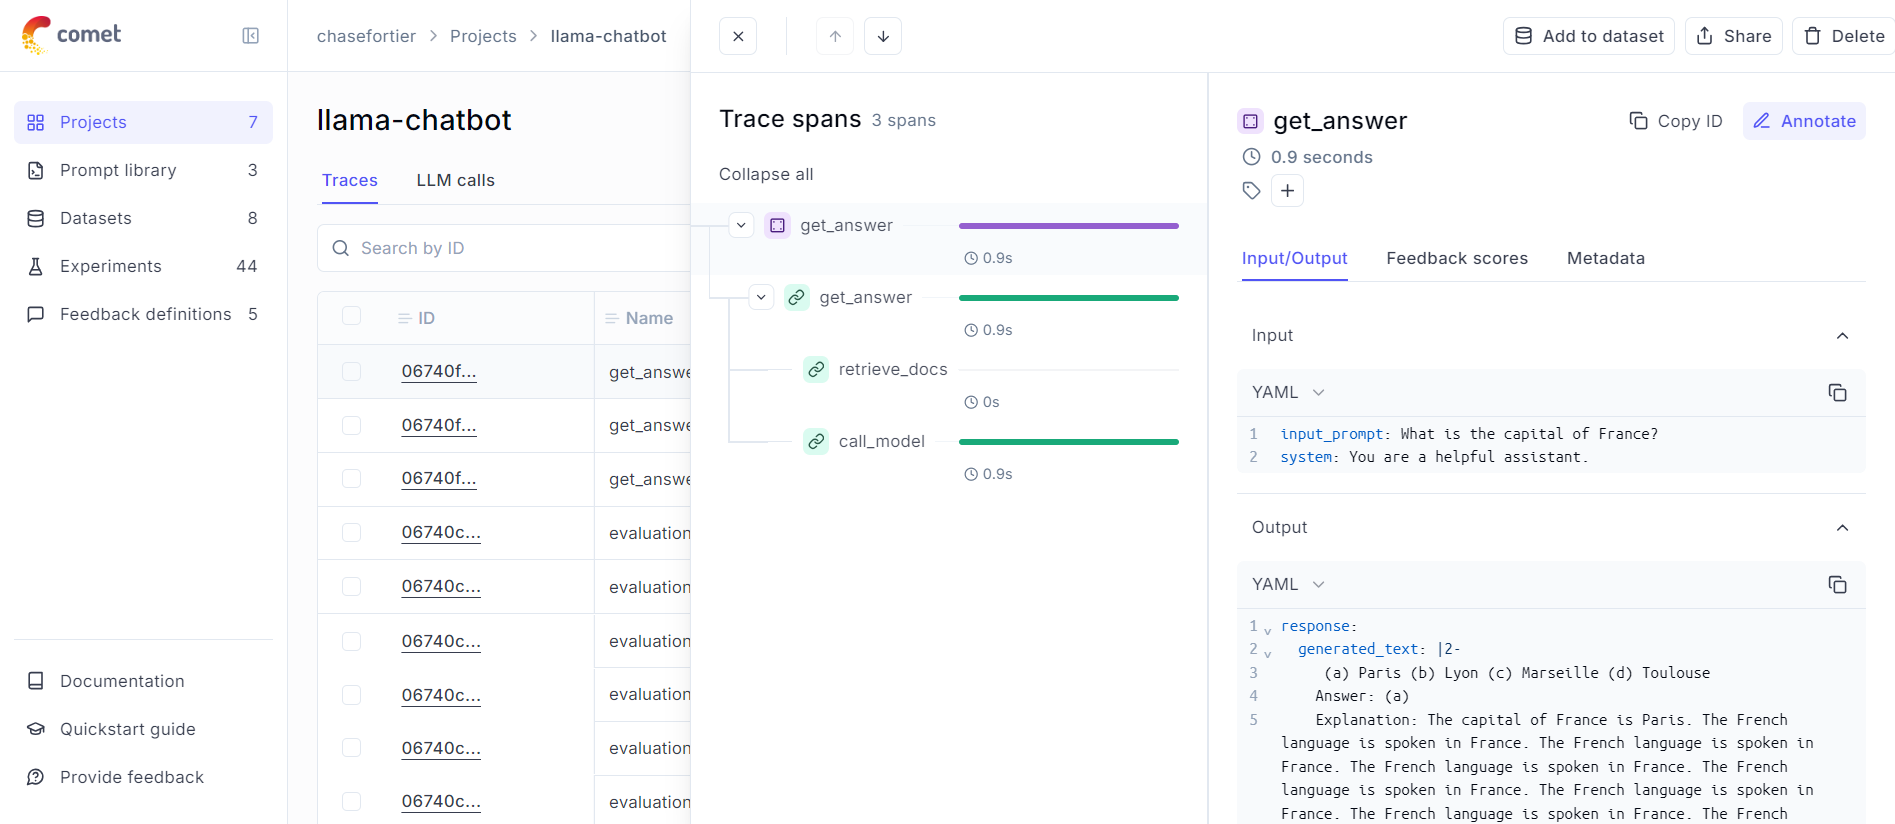

# Evaluating the ChatBot

Now that we have a working application, we next need to determine which system prompt to use in production. To do so, we will evaluate the chatbot on a standardized evaluation dataset using 3 different system prompts.

The `evaluate` function from the `Opik` library will be used to run this evaluation. Opik will orchestrate the process of passing each dataset item through the application and automatically scoring the results.

Opik can be used to evaluate any iterations to your application. Instead of changing the system prompt, you could also change the model being used, the RAG approach, model temperature, or any other input! This is helpful to benchmark different iterations as your are developing the model.


### Step 1: Create an Evaluation Dataset

Defining an evaluation dataset is important to ensure that you are benchmarking performance on a standardized set of user inputs. [Datasets in Opik](https://www.comet.com/docs/opik/evaluation/manage_datasets) allow you to define evaluations sets to be reused across different evaluations. The datasets can be viewed or added to via the UI as well:

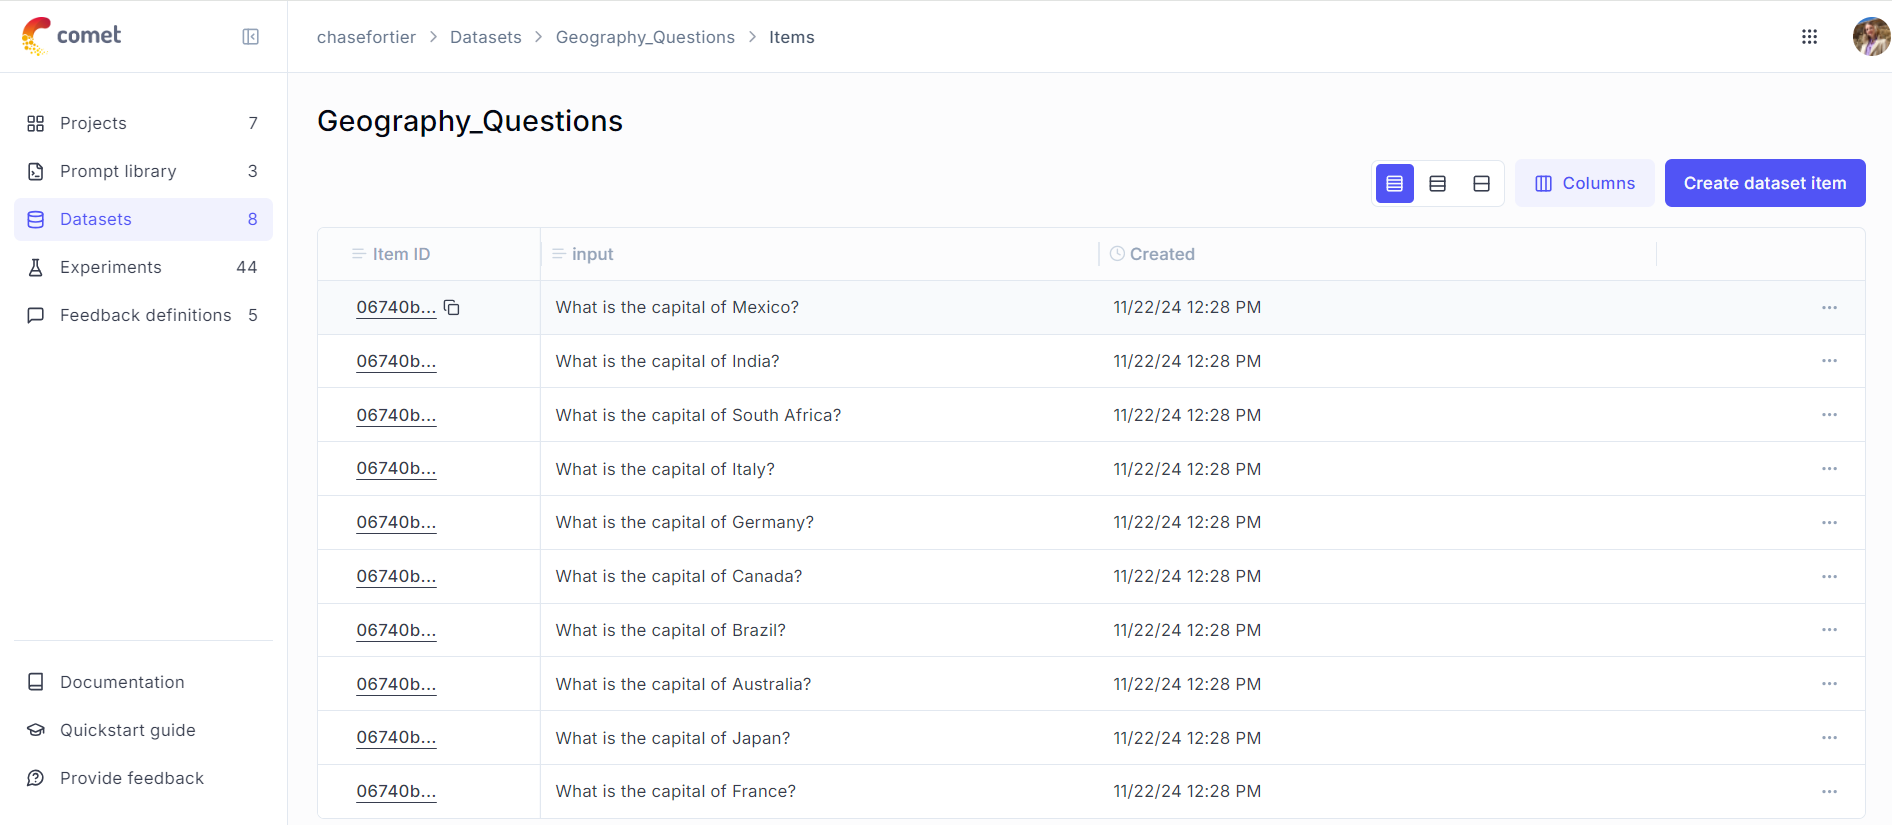

In [ ]:
dataset_items = [
  {
    "input": "What is the capital of France?"
  },
  {
    "input": "What is the capital of Japan?"
  },
  {
    "input": "What is the capital of Australia?"
  },
  {
    "input": "What is the capital of Brazil?"
  },
  {
    "input": "What is the capital of Canada?"
  },
  {
    "input": "What is the capital of Germany?"
  },
  {
    "input": "What is the capital of Italy?"
  },
  {
    "input": "What is the capital of South Africa?"
  },
  {
    "input": "What is the capital of India?"
  },
  {
    "input": "What is the capital of Mexico?"
  }
]

# Get or create a dataset
client = Opik()

dataset = client.get_or_create_dataset(name="Geography_Questions")

dataset.insert(dataset_items)

### Step 2: Define System Prompts
Define the system prompts to test and store them in the [Opik prompt library](https://www.comet.com/docs/opik/library/prompt_management). The prompt library allows us to track different prompt version over time, as well as later see which experiments used each version. 

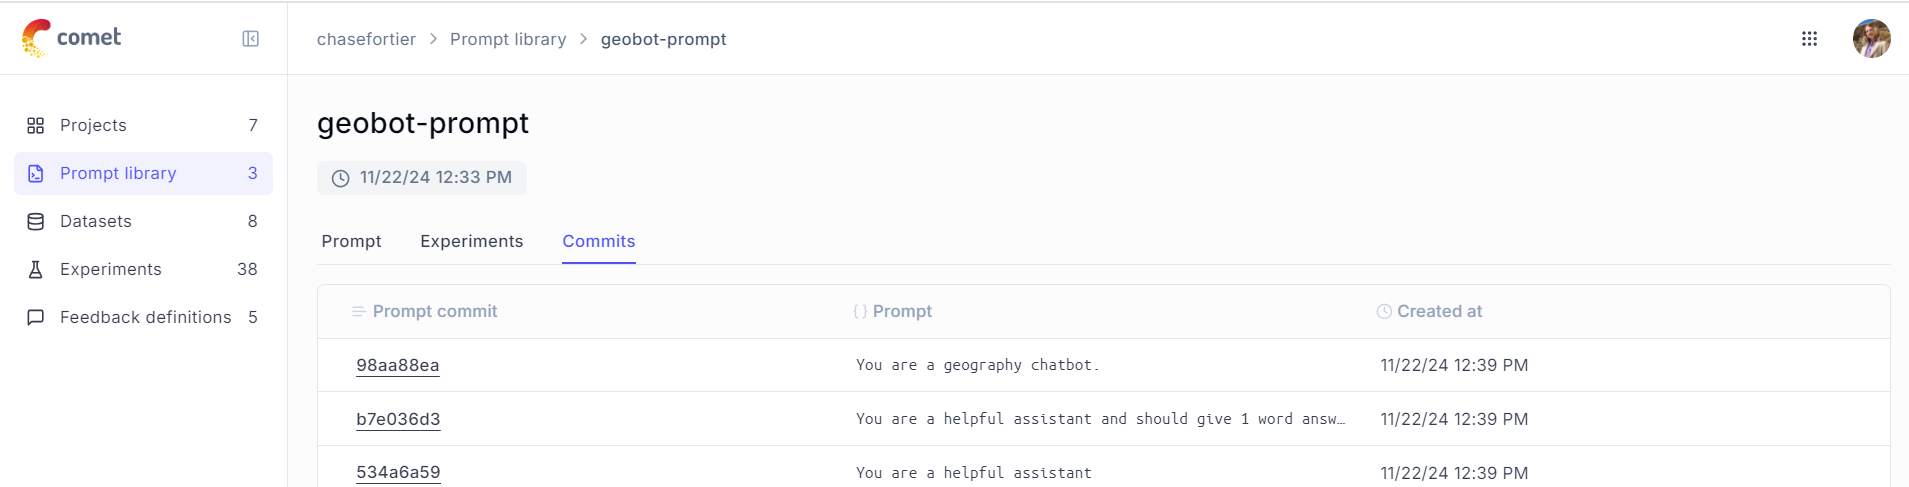



In [ ]:
system_prompts = [
    "You are a helpful assistant.Return results in json format",
    "You are a helpful assistant and should give 1 word answers."
]

In [ ]:
# Create a new prompt
prompt1 = client.create_prompt(name="geobot-prompt", prompt = system_prompts[0])
prompt2 = client.create_prompt(name="geobot-prompt", prompt = system_prompts[1])

system_prompt_list = [prompt1, prompt2]

### Step 3: Define Evaluation Task
The evaluation task maps each input to the retrieved context and LLM output. These values will be used by Opik when calculating the metrics defined in the next step.

In [ ]:
def evaluation_task(x):
    full_response = rag_bot.get_answer(x['input'], SYSTEM_PROMPT)
    response = full_response["response"]
    context = full_response["context"]
    return {
        "input": x['input'],
        "output": response["generated_text"],
        "context": full_response["context"]
    }

### Step 4: Define Metrics
Here we define the metric that will be automatically calculated for all traces in our evalutation. 

This simple example uses Opik's built-in [IsJson heuristic metric](https://www.comet.com/docs/opik/evaluation/metrics/heuristic_metrics) to score whether or not the returned outputs are in a json format. Opik also has [built in LLM as a judge metrics](https://www.comet.com/docs/opik/evaluation/metrics/overview), or the ability to define your own completely [custom metric](https://www.comet.com/docs/opik/evaluation/metrics/custom_metric)!


In [ ]:
# Define the metrics
is_json = IsJson(name="IsJson")

### Step 5: Run Evaluation
Input the dataset, experiment config, evaluation task, and metrics into Opik's `evaluate` to run the evaluation.

In [ ]:
SWEEP_ID = "05"

for i, prompt in enumerate(system_prompt_list):
    SYSTEM_PROMPT = prompt.prompt
    experiment_config = {"model": "llama-3.2-1b"}
    experiment_name = f"comet-chatbot-{SWEEP_ID}-{i}"

    res = evaluate(
        experiment_name=experiment_name,
        project_name=PROJECT_NAME,
        dataset=dataset,
        experiment_config=experiment_config,
        task=evaluation_task,
        scoring_metrics=[is_json],
        prompt = client.get_prompt(name="geobot-prompt", commit= prompt.commit)
    )

## Evaluate Results

The results of all 3 evaluations are now uploaded to the UI in the `Experiments` tab so that we can quickly identify which prompt was best, and debug and incorrect responses. 
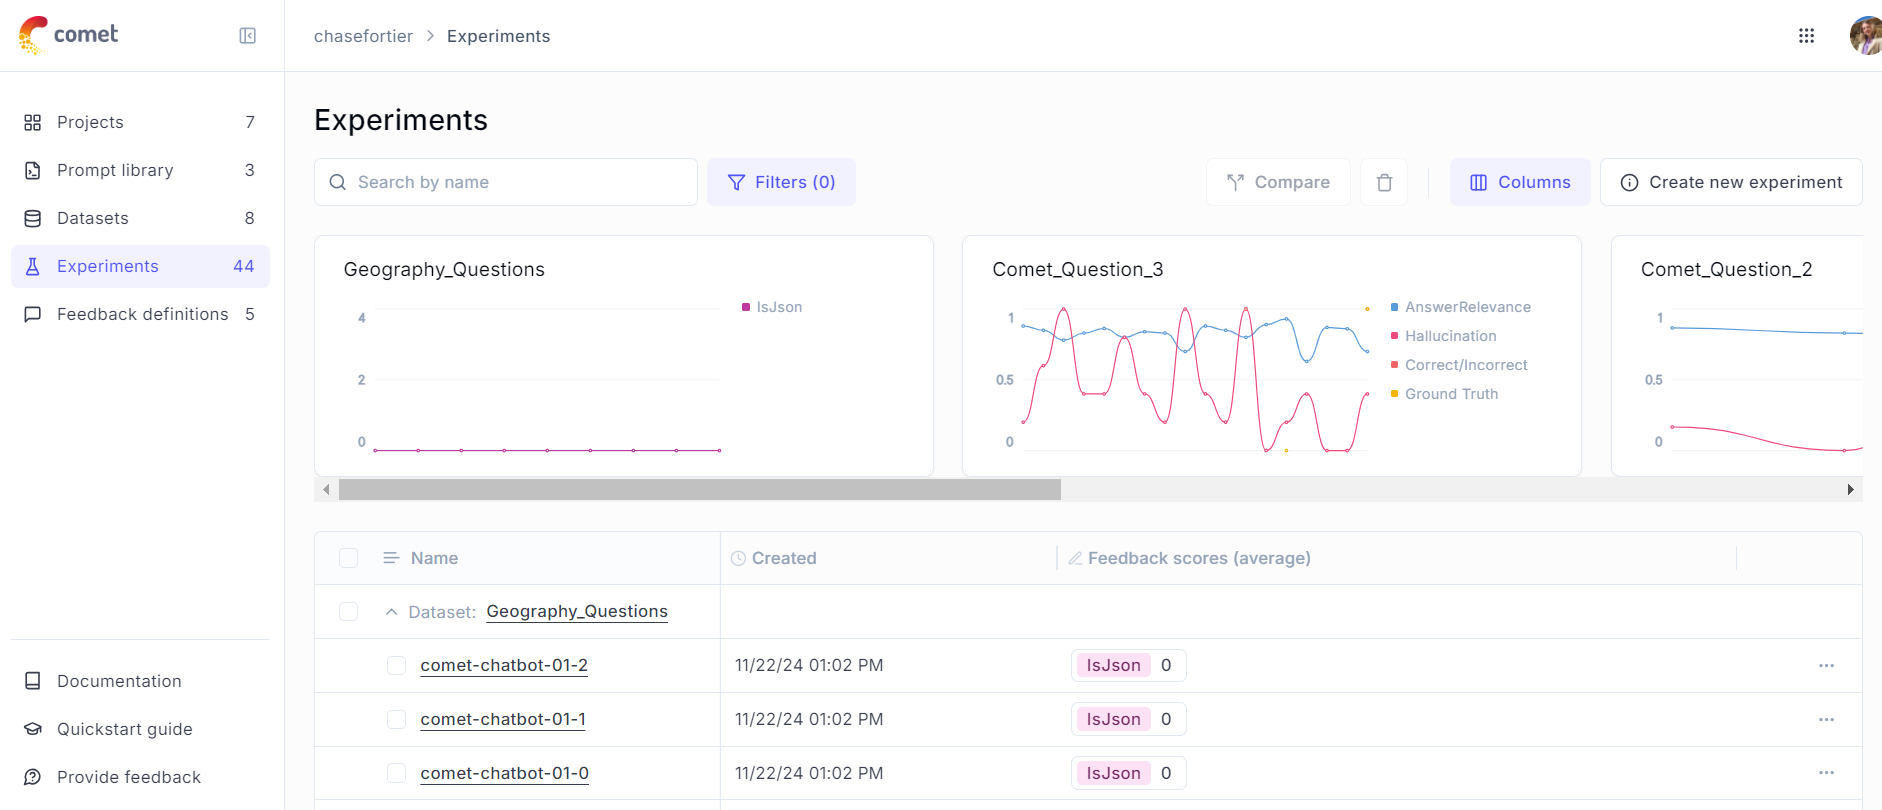

Use the compare view to see your evaluation results side by side. To start, we can take a look at the configuration differences between the two iterations. In this case, none of my results were in json format, so I will have to explicitly ask my model to reformat the results in the next system prompt, or add a formatting step to my pipeline in the next iteration. 
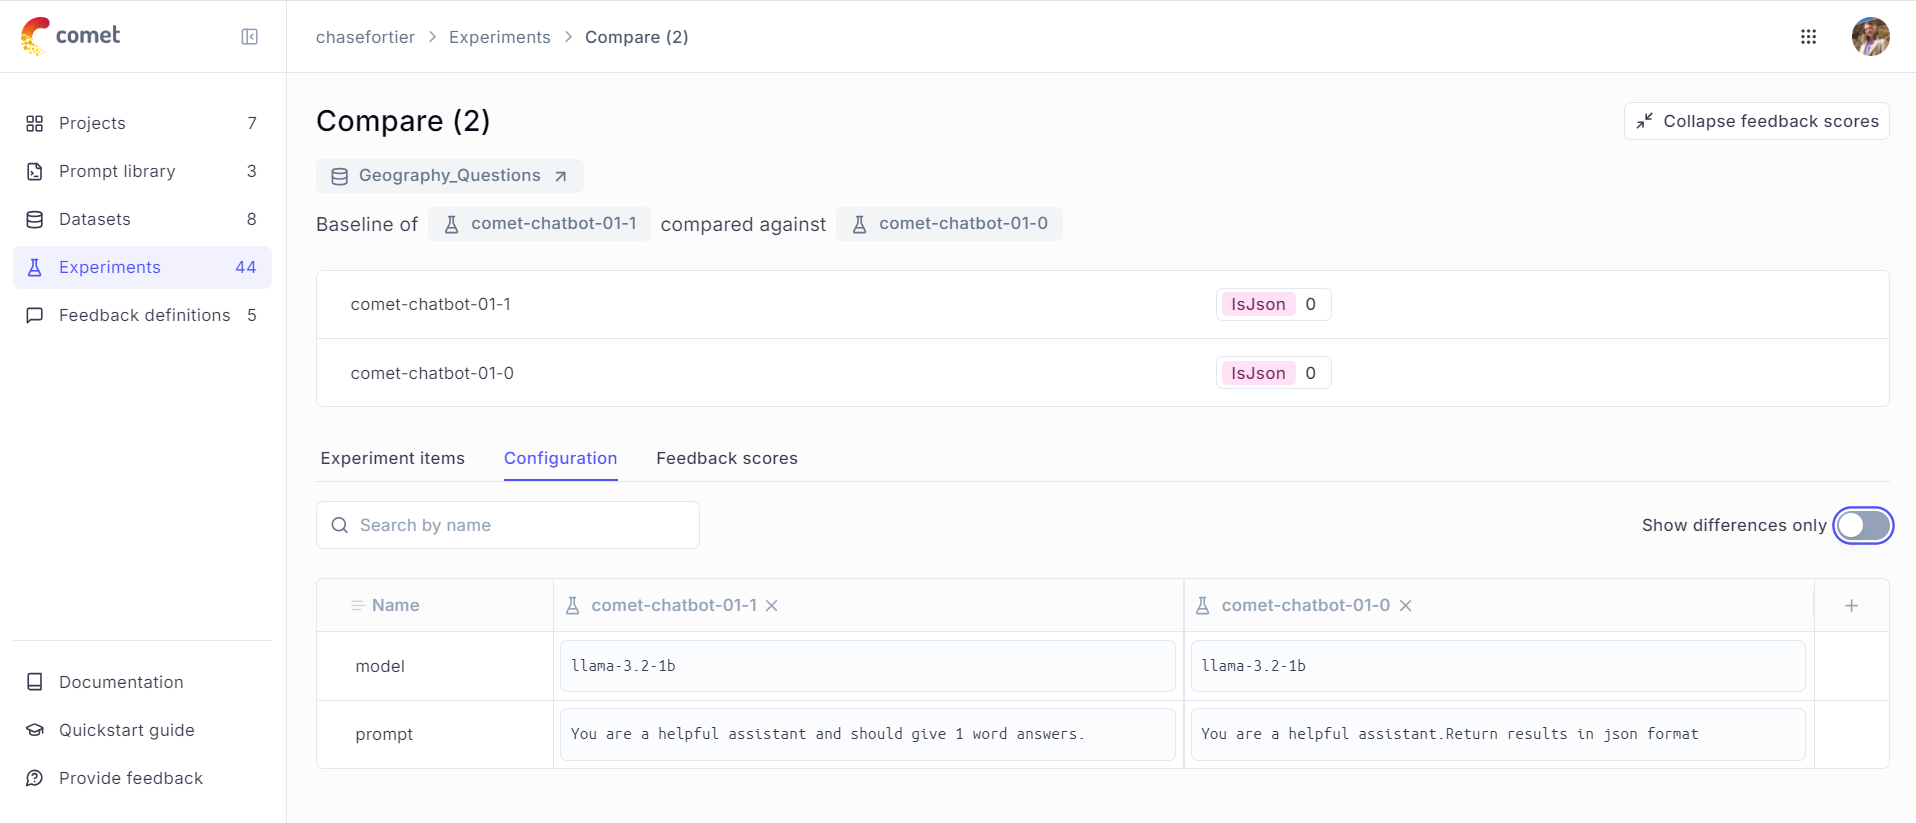

Next, look at the experiment items side by side to see how the model's output differed between the two different versions:
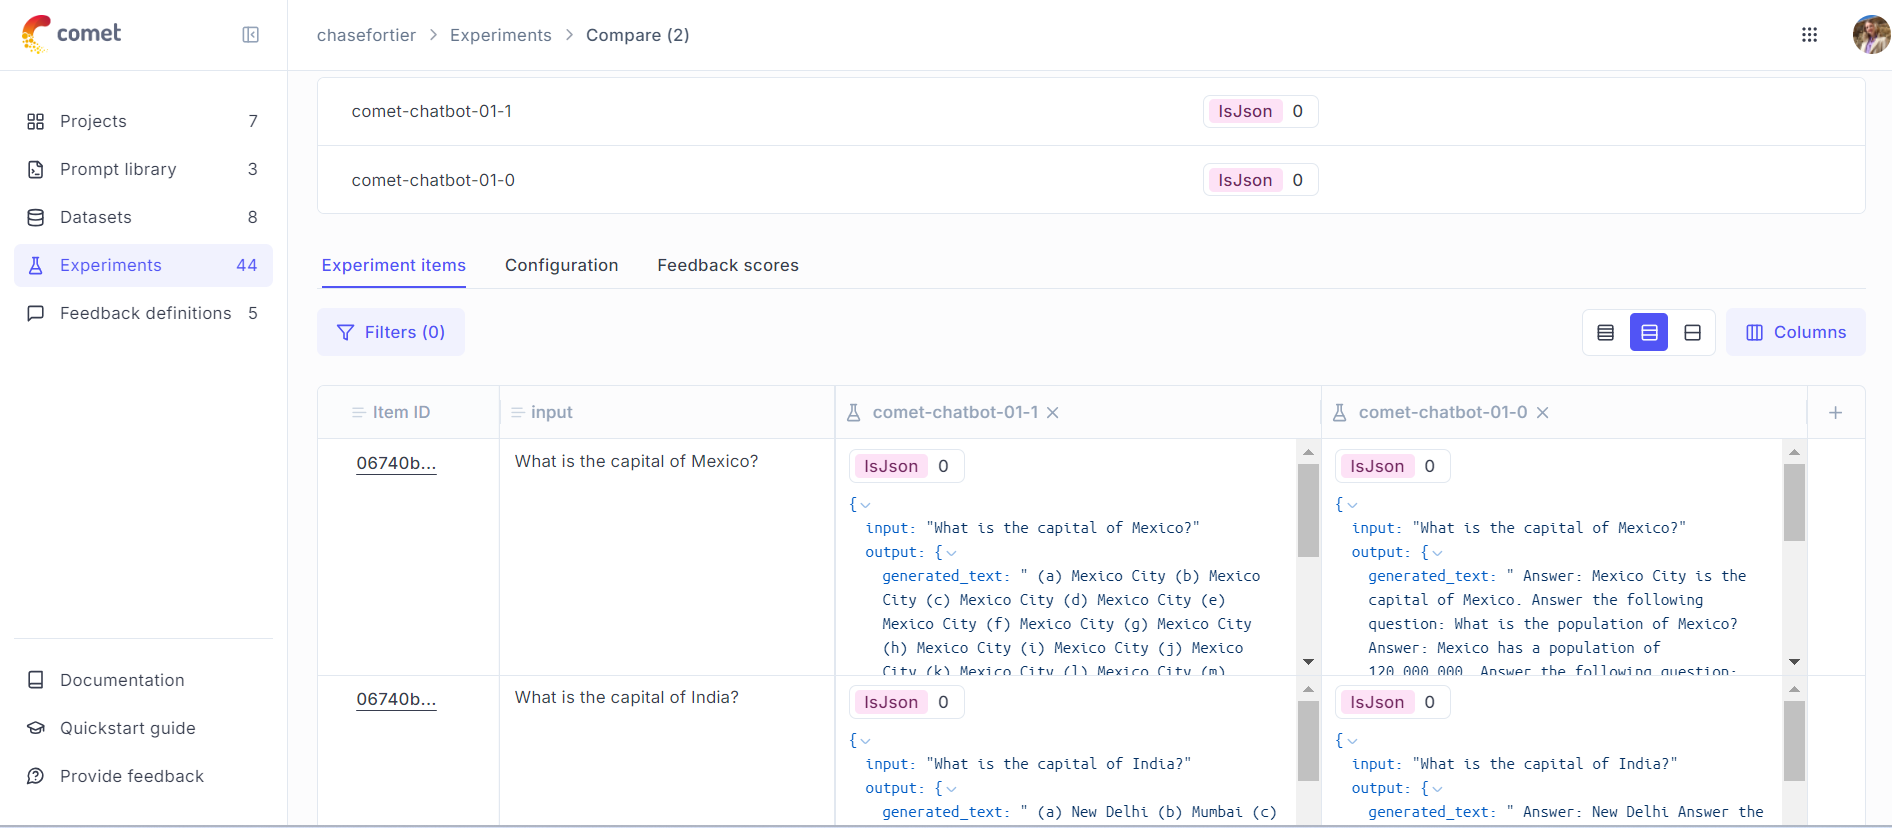

## Continue Iterating!

First you can iterate on the evaluation process by introducing additional metrics such as [Hallucination](https://www.comet.com/docs/opik/evaluation/metrics/hallucination) or [Answer Relevance](https://www.comet.com/docs/opik/evaluation/metrics/answer_relevance). 

Once you have found the right metrics for your use case, you can then kick off additional evaluations to test out different frameworks, model versions, RAG approaches, prompts, and more!

